<a href="https://colab.research.google.com/github/SambhavVinay/MusicGenreDetectionModel/blob/main/MusicGenreClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Install librosa for audio processing
!pip install librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Unzip your data ---
zip_file_path = '/content/archive (10).zip' # ⚠️ IMPORTANT: Change this to your exact file name!
extract_path = '/content/music_genres/'

print(f"Unzipping {zip_file_path}...")
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping complete! ✅")

# Path to the folder containing genre subfolders (e.g., 'rock', 'pop')
data_dir = os.path.join(extract_path, 'genres')

Unzipping /content/archive (10).zip...
Unzipping complete! ✅



Processing audio files and creating spectrograms...
Processing genre: pop
Processing genre: metal
Processing genre: disco
Processing genre: country
Processing genre: hiphop
Processing genre: jazz
Processing genre: rock
Processing genre: reggae
Processing genre: blues
Processing genre: classical

Preprocessing complete! ✅


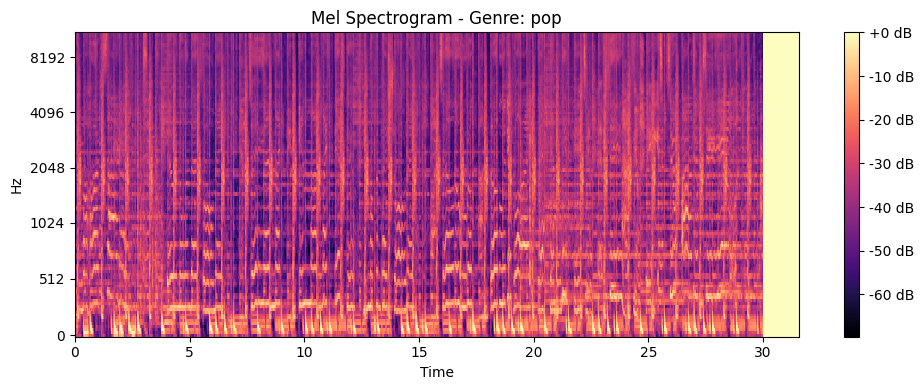

In [35]:
# --- Parameters for audio processing ---
SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
max_pad_len = 1360 # This will be the fixed width of our spectrograms

# Lists to store our spectrograms and their corresponding labels
spectrograms = []
labels = []

print("\nProcessing audio files and creating spectrograms...")

for genre_folder in os.listdir(data_dir):
    genre_path = os.path.join(data_dir, genre_folder)
    if os.path.isdir(genre_path):
        print(f"Processing genre: {genre_folder}")
        for filename in os.listdir(genre_path):
            if filename.endswith(('.wav', '.mp3', '.au')): # Add other audio formats if needed
                file_path = os.path.join(genre_path, filename)

                try:
                    # Load audio file
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

                    # Create a Mel spectrogram
                    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512)
                    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

                    # Pad or truncate spectrogram to a fixed size
                    if log_mel_spectrogram.shape[1] > max_pad_len:
                        log_mel_spectrogram = log_mel_spectrogram[:, :max_pad_len]
                    else:
                        pad_width = max_pad_len - log_mel_spectrogram.shape[1]
                        log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')

                    spectrograms.append(log_mel_spectrogram)
                    labels.append(genre_folder)
                except Exception as e:
                    print(f"Could not process {file_path}: {e}")

print("\nPreprocessing complete! ✅")

# --- Let's visualize one of the spectrograms ---
if spectrograms:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrograms[0], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - Genre: {labels[0]}')
    plt.tight_layout()
    plt.show()

In [36]:
# Convert lists to numpy arrays
X = np.array(spectrograms)
y = np.array(labels)

# Encode the genre labels from strings to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print("\nClasses and their encoded values:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {i}")


# Add a 'channel' dimension for the CNN (like a grayscale image)
X = X[..., np.newaxis]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("\nData shapes:")
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Classes and their encoded values:
blues: 0
classical: 1
country: 2
disco: 3
hiphop: 4
jazz: 5
metal: 6
pop: 7
reggae: 8
rock: 9

Data shapes:
Training data shape: (800, 128, 1360, 1)
Validation data shape: (200, 128, 1360, 1)


In [37]:
# Get the input shape from our processed data
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = Sequential([
  layers.Input(shape=input_shape),

  # Convolutional Block 1
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
  layers.BatchNormalization(), # Helps stabilize and speed up training

  # Convolutional Block 2
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
  layers.BatchNormalization(),

  # Convolutional Block 3
  layers.Conv2D(32, (2, 2), activation='relu'),
  layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
  layers.BatchNormalization(),

  # Flatten the output and feed it into dense layers
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.3), # Dropout helps prevent overfitting

  # Output layer
  layers.Dense(num_classes, activation='softmax')
])

# --- Compile the model ---
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


# --- Train the model ---
EPOCHS = 50 # Audio models often benefit from more epochs
BATCH_SIZE = 32



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 1358, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 679, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 679, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 677, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 339, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 339, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 338, 32)    │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 169, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 169, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 81120)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     5,191,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,206,474 (19.86 MB)

 Trainable params: 5,206,282 (19.86 MB)

 Non-trainable params: 192 (768.00 B)

In [38]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - accuracy: 0.2480 - loss: 2.4387 - val_accuracy: 0.1050 - val_loss: 40.5468
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.4269 - loss: 1.5255 - val_accuracy: 0.1050 - val_loss: 27.4239
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5889 - loss: 1.0750 - val_accuracy: 0.1100 - val_loss: 11.5071
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7137 - loss: 0.8001 - val_accuracy: 0.1600 - val_loss: 5.2607
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7833 - loss: 0.6595 - val_accuracy: 0.2200 - val_loss: 4.8858
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8461 - loss: 0.4643 - val_accuracy: 0.3750 - val_loss: 3.1899
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.8923 - loss: 0.3501 - val_accuracy: 0.3800 - val_loss: 3.0162
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8891 - loss: 0.3179 - val_accuracy

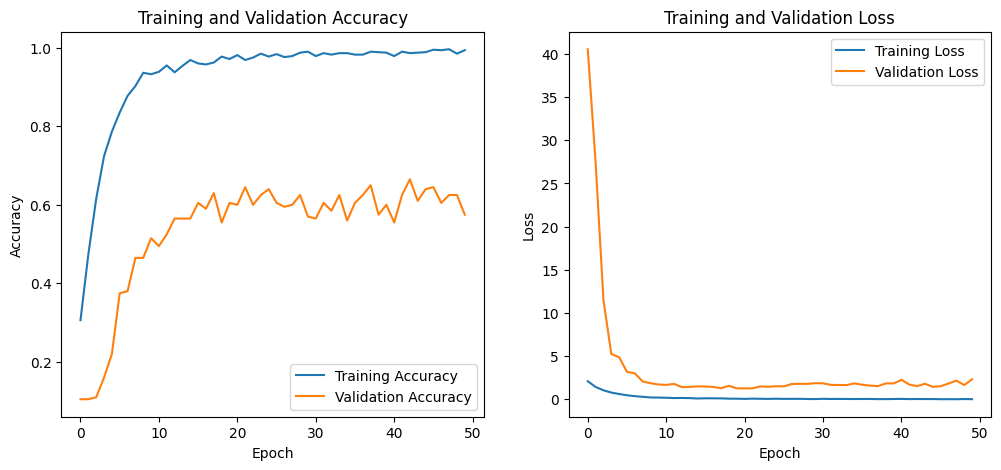

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [45]:
import random
from IPython.display import Audio

# --- 1. Select a random audio file from your dataset ---
# Get a list of genre folder names
genre_list = os.listdir(data_dir)
# Pick a random genre
random_genre = random.choice(genre_list)
random_genre_path = os.path.join(data_dir, random_genre)
# Pick a random audio file from that genre
random_audio_file = random.choice(os.listdir(random_genre_path))
file_path = os.path.join(random_genre_path, random_audio_file)

print(f"Selected file: {random_audio_file}")
print(f"Actual Genre: {random_genre}")

# --- 2. Play the audio file ---
print("\nPlaying audio:")
display(Audio(file_path))

# --- 3. Preprocess the single audio file (must be identical to training) ---
try:
    # Load and process the audio file
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pad or truncate to the fixed size
    if log_mel_spectrogram.shape[1] > max_pad_len:
        log_mel_spectrogram = log_mel_spectrogram[:, :max_pad_len]
    else:
        pad_width = max_pad_len - log_mel_spectrogram.shape[1]
        log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Reshape for the model (add channel and batch dimensions)
    spectrogram_for_model = np.expand_dims(log_mel_spectrogram, axis=-1) # Add channel dim
    spectrogram_for_model = np.expand_dims(spectrogram_for_model, axis=0) # Add batch dim

    # --- 4. Make a prediction ---
    prediction = model.predict(spectrogram_for_model)
    predicted_index = np.argmax(prediction, axis=1)[0]

    # --- 5. Decode and display the result ---
    predicted_genre = label_encoder.inverse_transform([predicted_index])[0]

    print(f"\n🤖 Model Prediction: {predicted_genre.upper()}")

except Exception as e:
    print(f"\nCould not process or predict the file. Error: {e}")

Selected file: pop.00076.au
Actual Genre: pop

Playing audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

🤖 Model Prediction: POP


In [46]:
from google.colab import files
from IPython.display import Audio
import os

# --- 1. Upload your audio file ---
print("Please upload an audio file (e.g., .wav, .mp3)...")
uploaded = files.upload()

# Check if a file was uploaded
if len(uploaded.keys()) == 0:
    print("No file was uploaded. Please run the cell again.")
else:
    # --- 2. Get the path and play the audio ---
    # Get the name of the file you uploaded
    filename = next(iter(uploaded))
    file_path = os.path.join('/content/', filename)

    print(f"\nUploaded file: {filename}")
    print("Playing your audio:")
    display(Audio(file_path))

    # --- 3. Preprocess the file and make a prediction ---
    try:
        # Load audio file
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        # Create a Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Pad or truncate spectrogram to the fixed size used in training
        if log_mel_spectrogram.shape[1] > max_pad_len:
            log_mel_spectrogram = log_mel_spectrogram[:, :max_pad_len]
        else:
            pad_width = max_pad_len - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')

        # Reshape for the model's input layer
        spectrogram_for_model = np.expand_dims(log_mel_spectrogram, axis=-1) # Add channel dimension
        spectrogram_for_model = np.expand_dims(spectrogram_for_model, axis=0) # Add batch dimension

        # --- 4. Get the model's prediction ---
        prediction = model.predict(spectrogram_for_model)

        # Get the index of the highest probability
        predicted_index = np.argmax(prediction, axis=1)[0]

        # Convert the index back to the genre name
        predicted_genre = label_encoder.inverse_transform([predicted_index])[0]

        print("-" * 30)
        print(f"🤖 Model Prediction: The genre is **{predicted_genre.upper()}**")
        print("-" * 30)

    except Exception as e:
        print(f"\nAn error occurred while processing the file: {e}")
        print("Please ensure you uploaded a valid audio file.")

Please upload an audio file (e.g., .wav, .mp3)...


Saving metal.00088.au to metal.00088.au

Uploaded file: metal.00088.au
Playing your audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
------------------------------
🤖 Model Prediction: The genre is **REGGAE**
------------------------------
